# Packages

In [131]:
# Base
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Feature selection
from sklearn.ensemble import ExtraTreesClassifier

# Balanced set creation
from imblearn.over_sampling import SMOTE

# Logistic regression
from sklearn import linear_model

# Metrics
from sklearn.metrics import accuracy_score, auc, classification_report, confusion_matrix, roc_curve

# Get data

In [132]:
# Read CSV
path = 'telco.csv'
df = pd.read_csv(path)

# Check import
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# Drop customer ID
We cannot use that as a feature.

In [133]:
# Drop columns
df.drop('customerID', axis = 1, inplace = True)

# Change data types

In [134]:
# Check types
print(df.dtypes)

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object


In [135]:
# Change type of total charges to float
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
print(df.dtypes)

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object


# Handle missing values

In [136]:
# Count number of missing values
print(df.shape[0] - df.count())

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64


In [137]:
# Replace missing values for feature 'TotalCharges'
df['TotalCharges'].fillna(0.0, inplace = True)

# Explore data

In [138]:
# Check shape
print(df.shape)

(7043, 20)


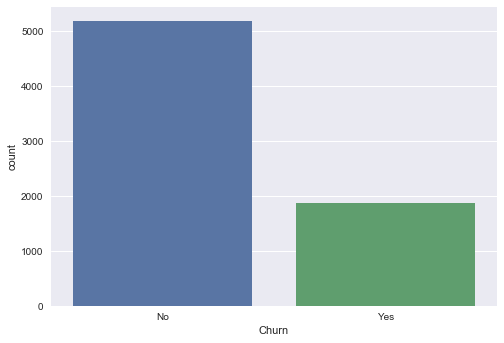

Churn
No     5174
Yes    1869
dtype: int64


In [139]:
# Check number of clients that have left
sns.countplot(df['Churn'])
plt.show()
print(df.groupby('Churn').size())

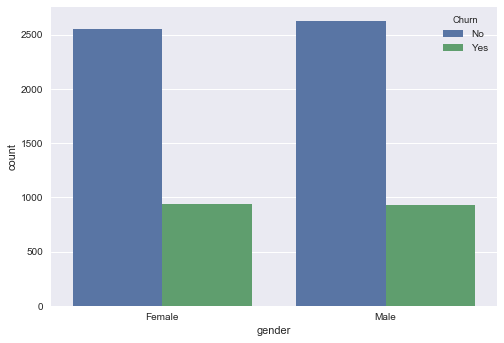

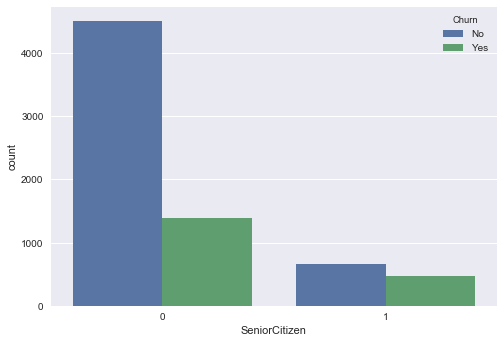

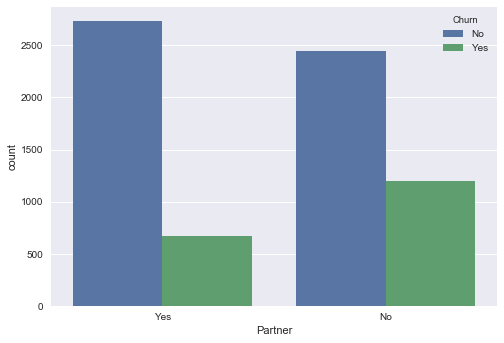

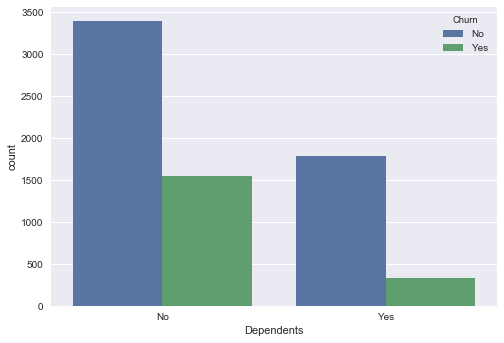

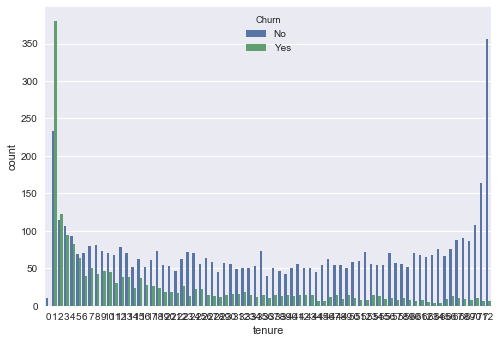

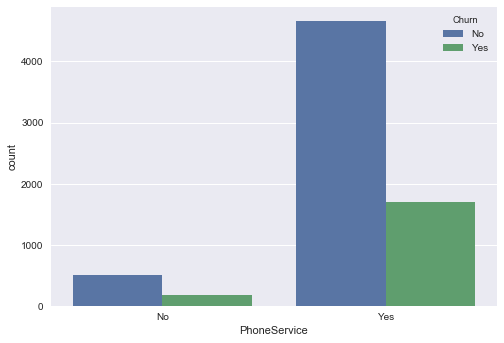

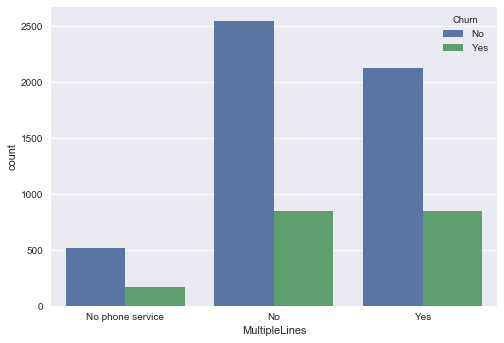

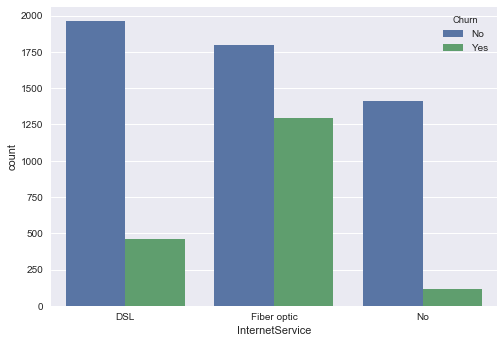

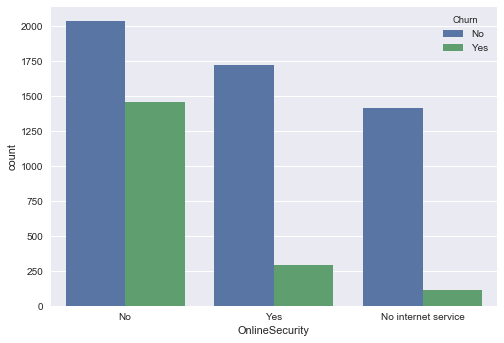

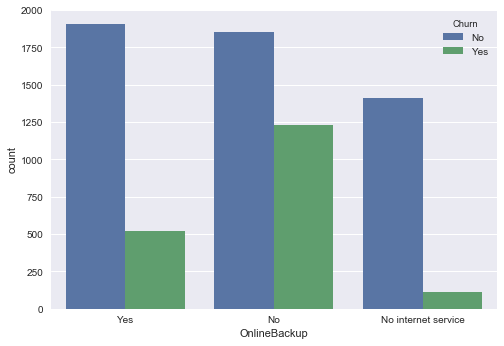

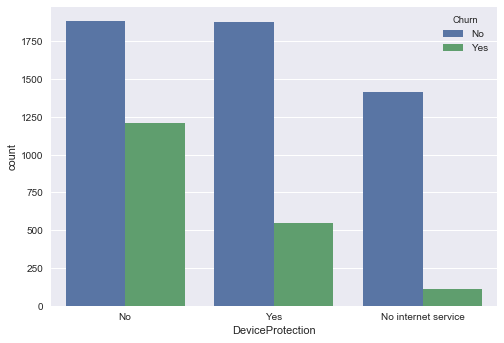

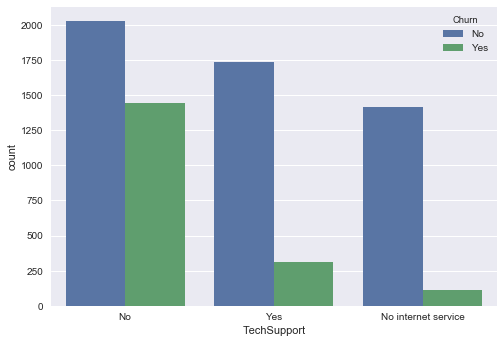

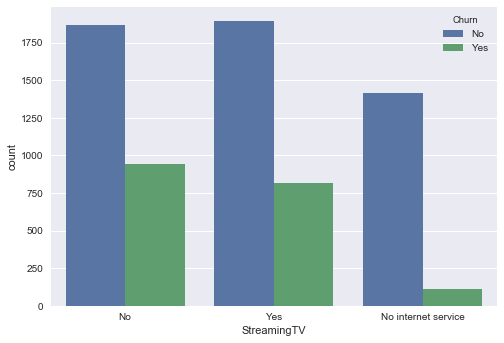

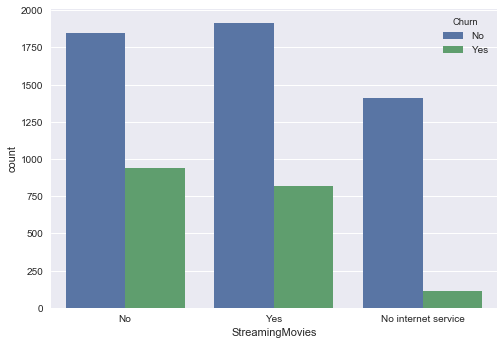

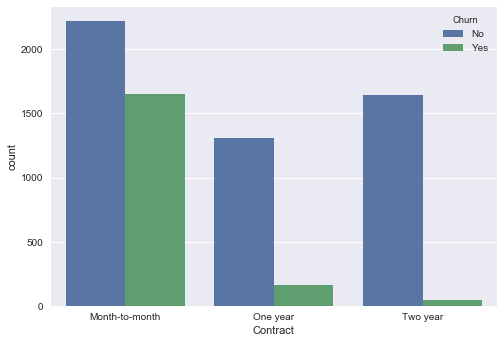

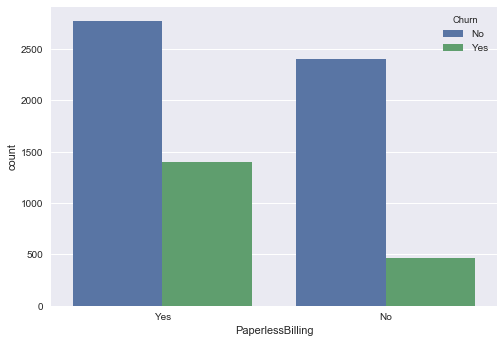

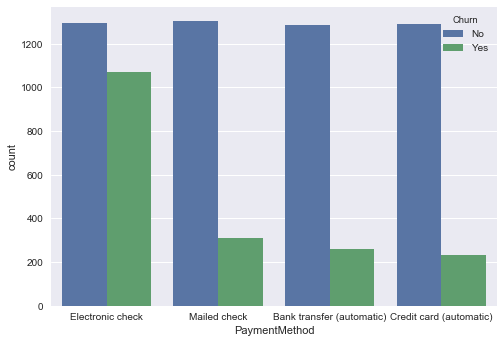

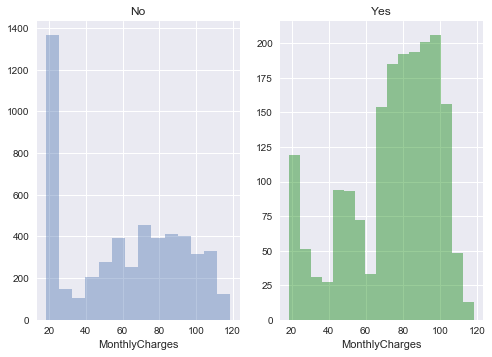

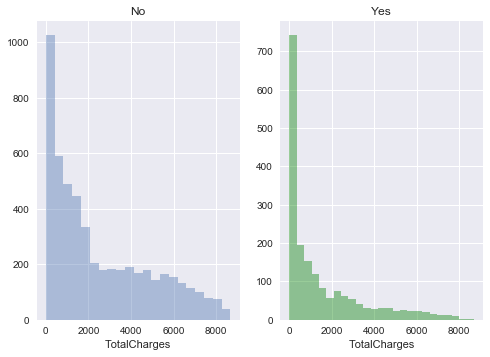

In [140]:
# Plot all distributions
for c in df.columns:
    if c == 'Churn':
        continue
    elif (df[c].dtype == np.object) or (df[c].dtype == np.int64):
        sns.countplot(x = c, hue = 'Churn', data = df)
        plt.show()
    else:
        f,a = plt.subplots(1, 2)
        sns.distplot(df[df['Churn'] == 'No'][c], kde = False, rug = False, ax = a[0])
        a[0].set_title('No')
        sns.distplot(df[df['Churn'] == 'Yes'][c], kde = False, rug = False, ax = a[1], color = 'g')
        a[1].set_title('Yes')
        plt.show()

# Transform categorical features into one feature by category
Map binary variables to 0/1. I could also use 'astype('category')' and 'pd.get_dummies' but we would then need to remove each time a column (since when k categories, we keep only k-1 features).

In [141]:
# Target
df['Churn'] = df['Churn'].map(lambda x: 1 if x == 'Yes' else 0)

# Features
df['gender'] = df['gender'].map(lambda x: 1 if x == 'Male' else 0)
df['Partner'] = df['Partner'].map(lambda x: 1 if x == 'Yes' else 0)
df['PhoneService'] = df['PhoneService'].map(lambda x: 1 if x == 'Yes' else 0)
df['PaperlessBilling'] = df['PaperlessBilling'].map(lambda x: 1 if x == 'Yes' else 0)
df['Dependents'] = df['Dependents'].map(lambda x: 1 if x == 'Yes' else 0)

Create 1 feature for each category.

In [142]:
# Set type 'category'
df['OnlineSecurity'] = df['OnlineSecurity'].astype('category')
df['OnlineBackup'] = df['OnlineBackup'].astype('category')
df['DeviceProtection'] = df['DeviceProtection'].astype('category')
df['TechSupport'] = df['TechSupport'].astype('category')
df['StreamingTV'] = df['StreamingTV'].astype('category')
df['StreamingMovies'] = df['StreamingMovies'].astype('category') 
df['MultipleLines'] = df['MultipleLines'].astype('category') 
df['InternetService'] = df['InternetService'].astype('category') 
df['Contract'] = df['Contract'].astype('category') 
df['PaymentMethod'] = df['PaymentMethod'].astype('category') 

# Select categorical features
for c in df.select_dtypes(include=['category']):
    print(c)

# Do categorical encoding, removing automatically one of the categories
# COMMENT: I did not do that so that I could choose which category to drop
# df = pd.get_dummies(df, drop_first = True)

# Do categorical encoding without dropping one of the categories
df = pd.get_dummies(df, drop_first = False)

MultipleLines
InternetService
OnlineSecurity
OnlineBackup
DeviceProtection
TechSupport
StreamingTV
StreamingMovies
Contract
PaymentMethod


In [143]:
# Check existing columns in data frame
print(df.dtypes)

gender                                       int64
SeniorCitizen                                int64
Partner                                      int64
Dependents                                   int64
tenure                                       int64
PhoneService                                 int64
PaperlessBilling                             int64
MonthlyCharges                             float64
TotalCharges                               float64
Churn                                        int64
MultipleLines_No                             uint8
MultipleLines_No phone service               uint8
MultipleLines_Yes                            uint8
InternetService_DSL                          uint8
InternetService_Fiber optic                  uint8
InternetService_No                           uint8
OnlineSecurity_No                            uint8
OnlineSecurity_No internet service           uint8
OnlineSecurity_Yes                           uint8
OnlineBackup_No                

# Add new features

In [144]:
# Add number of services
df['extraServicesNumber'] =  df['OnlineSecurity_Yes'] + df['OnlineBackup_Yes'] + df['DeviceProtection_Yes'] + df['TechSupport_Yes'] + df['StreamingTV_Yes'] + df['StreamingMovies_Yes']
df['phoneInternet'] = df['PhoneService'] * df['InternetService_DSL'] + df['PhoneService'] * df['InternetService_Fiber optic']

# Compute duration
#df['duration'] = df['TotalCharges'] / df['MonthlyCharges']

# Drop some features
Since we only need k-1 features for k categories. But I finally decided to merge categorical variables 'No' and 'No internet service', see #.

In [145]:
# Drop columns
baseline = ['MultipleLines_No phone service', 
            'MultipleLines_No', #
            'InternetService_No',
            'OnlineSecurity_No internet service',
            'OnlineSecurity_No', #
            'OnlineBackup_No internet service',
            'OnlineBackup_No', #
            'DeviceProtection_No internet service',
            'DeviceProtection_No', #
            'TechSupport_No internet service',
            'TechSupport_No', #
            'StreamingTV_No internet service',
            'StreamingTV_No', #
            'StreamingMovies_No internet service',
            'StreamingMovies_No', #
            'Contract_Month-to-month',
            'PaymentMethod_Mailed check'
           ]
df.drop(baseline, axis = 1, inplace = True)

# Print all available columns
for c in list(df.columns.values):
    print(c)

gender
SeniorCitizen
Partner
Dependents
tenure
PhoneService
PaperlessBilling
MonthlyCharges
TotalCharges
Churn
MultipleLines_Yes
InternetService_DSL
InternetService_Fiber optic
OnlineSecurity_Yes
OnlineBackup_Yes
DeviceProtection_Yes
TechSupport_Yes
StreamingTV_Yes
StreamingMovies_Yes
Contract_One year
Contract_Two year
PaymentMethod_Bank transfer (automatic)
PaymentMethod_Credit card (automatic)
PaymentMethod_Electronic check
extraServicesNumber
phoneInternet


# Display correlation

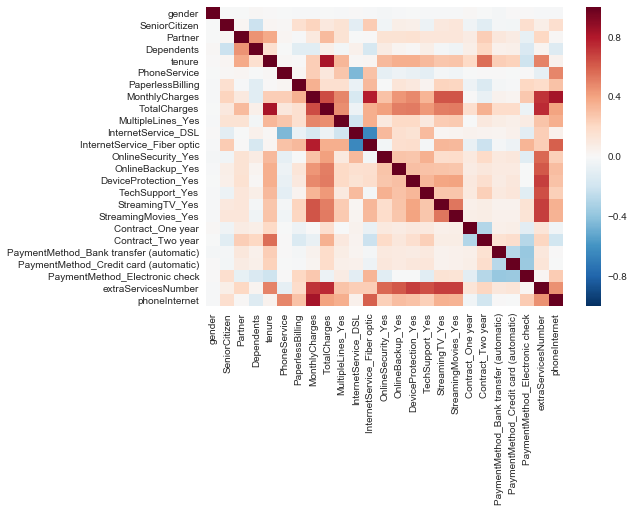

In [146]:
# Display correlation
corr = sns.heatmap(df.drop('Churn', axis = 1).corr())

# Rotate axes
for text in corr.get_yticklabels():
    text.set_rotation('horizontal')
for text in corr.get_xticklabels():
    text.set_rotation('vertical')
plt.show()

# Split data into test set and train set
I use a SMOTE technique for creating balanced a balanced set. Many other methods exists, see http://contrib.scikit-learn.org/imbalanced-learn/.

In [147]:
# Separate features from target
X_imb = df.drop('Churn', axis = 1)
y_imb = df['Churn']

# Create balanced set using SMOTE
rus = SMOTE(random_state = 64)
X, y = rus.fit_sample(X_imb, y_imb)
# IMPORTANT: X and y are numpy arrays while X_imb and y_imb are data frames.

# Create train set and test set
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 13)

# Feature selection
Many possibilities exists for selecting features:
- univariate tests (SelectKBest)
- RFE
- ...

In [148]:
# Train tree classifier
model = ExtraTreesClassifier(n_estimators = 200, random_state = 13)
model.fit(X_train, y_train)
importances = model.feature_importances_

support = importances > np.mean(importances)
selected_feature_flag = dict(zip(X_imb.columns, support))
selected_features = [k for k,v in selected_feature_flag.items() if v == True]
print(selected_features)

# Apply feature selection on train and test sets
X_train = X_train[:, support]
X_test = X_test[:, support]

['tenure', 'PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'InternetService_Fiber optic', 'Contract_One year', 'Contract_Two year', 'PaymentMethod_Electronic check']


# Logistic regression (using scikit-learn)

In [149]:
# Train
log_reg = linear_model.LogisticRegression(C=100)
log_reg.fit(X_train, y_train)

print('\nCoefficients: ',log_reg.coef_)


Coefficients:  [[ -5.45793962e-02   5.35491611e-01   5.95321086e-03   2.81846148e-04
    8.20671032e-01  -9.49768472e-01  -1.79949176e+00   6.35281623e-01]]


In [150]:
print(np.exp(log_reg.coef_))

[[ 0.94688333  1.70828785  1.00597097  1.00028189  2.27202393  0.38683058
   0.16538292  1.88755365]]


In [151]:
def evaluate_model(_X_test, _y_test, _y_hat):
    
    # ROC
    FP_rate, TP_rate, thresholds = roc_curve(_y_test, _y_hat)
    roc_auc = auc(FP_rate, TP_rate)
    plt.plot(FP_rate, TP_rate, 'r', label=roc_auc)
    plt.title('ROC')
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'navy')
    plt.xlim([0.0,1.05])
    plt.ylim([0.0,1.05])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    # Convert to class
    _y_hat = (_y_hat > 0.5).astype('int')
    
    # Metrics
    print('\nReport', classification_report(_y_test, _y_hat))
    print('\nAccuracy', accuracy_score(_y_test, _y_hat))
    print('\nConfusion matrix', confusion_matrix(_y_test, _y_hat))

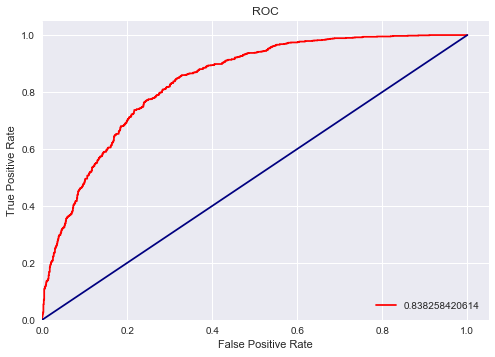


Report              precision    recall  f1-score   support

          0       0.79      0.72      0.75      1067
          1       0.73      0.80      0.76      1003

avg / total       0.76      0.76      0.76      2070


Accuracy 0.757971014493

Confusion matrix [[768 299]
 [202 801]]


In [152]:
# Predict proba
y_hat = log_reg.predict_proba(X_test)[:, 1]

# Evaluate
evaluate_model(X_test, y_test, y_hat)

# Logistic regression (using statsmodels)
I like statsmodels version of the logistic regression because of its result summary.

In [153]:
import statsmodels.api as sm

# Convert to data frame 
X_train_df = pd.DataFrame(X_train, columns = selected_features)

# Train model
log_reg_sm = sm.Logit(y_train, X_train_df)
results_sm = log_reg_sm.fit()

Optimization terminated successfully.
         Current function value: 0.480541
         Iterations 7


In [154]:
print(results_sm.summary())
# Rule of thumb: 
# If abs(z)>2, then the variable is important to the model. 
# It corresponds approximatively to a hypothesis test wiht a significance level of a alpha of 0.05.

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 8278
Model:                          Logit   Df Residuals:                     8270
Method:                           MLE   Df Model:                            7
Date:                Tue, 07 Mar 2017   Pseudo R-squ.:                  0.3067
Time:                        20:38:54   Log-Likelihood:                -3977.9
converged:                       True   LL-Null:                       -5737.6
                                        LLR p-value:                     0.000
                                     coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------------
tenure                            -0.0604      0.004    -14.798      0.000        -0.068    -0.052
PaperlessBilling                   0.4825      0.064      7.510      0.

In [155]:
print(np.exp(results_sm.params))

tenure                            0.941352
PaperlessBilling                  1.620141
MonthlyCharges                    1.003301
TotalCharges                      1.000368
InternetService_Fiber optic       2.210803
Contract_One year                 0.372246
Contract_Two year                 0.139806
PaymentMethod_Electronic check    1.882651
dtype: float64


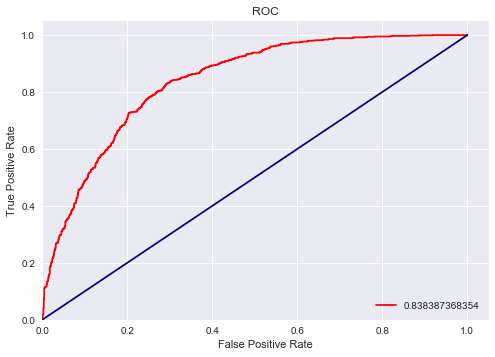


Report              precision    recall  f1-score   support

          0       0.82      0.70      0.75      1067
          1       0.72      0.83      0.77      1003

avg / total       0.77      0.76      0.76      2070


Accuracy 0.764734299517

Confusion matrix [[746 321]
 [166 837]]


In [156]:
# Get proba
y_hat = log_reg_sm.predict(results_sm.params, X_test)

# Evaluate model
evaluate_model(X_test, y_test, y_hat)